<a href="https://colab.research.google.com/github/Jawakar-7/Lesion-Detection-using-Mammograms/blob/main/Lesions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/Jawakar-7/Lesion-Detection-using-Mammograms

fatal: destination path 'Lesion-Detection-using-Mammograms' already exists and is not an empty directory.


# Downloading Dataset from Kaggle

In [2]:
! mkdir ~/.kaggle
! cp /content/Lesion-Detection-using-Mammograms/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d skooch/ddsm-mammography

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ddsm-mammography.zip: Skipping, found more recently modified local copy (use --force to force download)


# Extracting Data

In [3]:
import zipfile
path= '/kaggle/working/ddsm-mammography.zip'  #  path to  zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')  #extraction path


# Importing Necessary Libraries

In [4]:
# import dependencies
import glob
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }
Image_height = 224
Image_width = 224

## Data Extraction and Preprocessing

In [6]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    
    return parsed_example

In [7]:
def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))

    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    i=0
    for image_features in full_dataset:
        
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image=image.numpy()
        image=cv2.resize(image,(Image_height,Image_width))
        image=cv2.merge([image,image,image])

        images.append(image)
        labels.append(image_features['label_normal'].numpy())


In [8]:
filenames=[
    '/kaggle/working/training10_0/training10_0.tfrecords',
    '/kaggle/working//training10_1/training10_1.tfrecords',
    '/kaggle/working/training10_2/training10_2.tfrecords',

          ]

for file in filenames:
    read_data(file)


<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [9]:
print(len(images))


33531


(224, 224, 3)


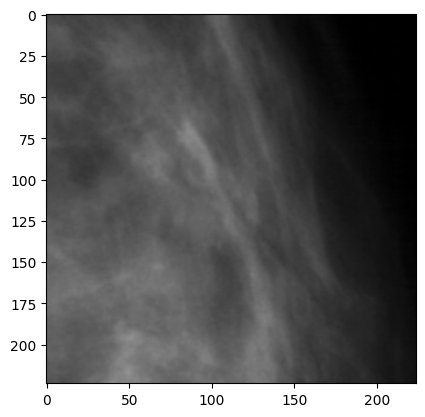

In [10]:
images = np.array(images)
labels = np.array(labels)



plt.imshow(images[19])
print(images[0].shape)

# Train Test Split 

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, stratify = labels, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.50, stratify = y_test, random_state=50)

## Model Architecture

In [12]:
in_lay = Input(x_train.shape[1:])
base_pretrained_model = VGG16(input_shape = x_train.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_features = base_pretrained_model(in_lay)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)
# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
                        
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'sigmoid')(dr_steps)

final_model = Model(inputs = [in_lay], outputs = [out_layer])


In [13]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 512)   2048        ['vgg16[1][0]']                  
 alization)                                                                                       
                                                                                              

## Hyperparameter Tuning Methods

In [14]:
weight_path="{}_weights.best.keras".format('breast_cancer')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.00001)
#reduceLROnPlat = ReduceLROnPlateau()
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [15]:
final_model.compile(tf.keras.optimizers.Adam(learning_rate=.001),
              loss='binary_crossentropy', 
              metrics=['acc'])
     

# train the model

history = final_model.fit(x_train, y_train, 
                          steps_per_epoch=len(x_train)//8,
                          epochs=10,
                          validation_data = (x_val, y_val),
                          validation_steps = len(x_val)//8, 
                          callbacks = callbacks_list
                        )

loss_value , accuracy = final_model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))
     


Epoch 1/10
3352/3353 [============================>.] - ETA: 0s - loss: 0.2911 - acc: 0.8851
Epoch 1: val_loss improved from inf to 0.23084, saving model to breast_cancer_weights.best.keras
3353/3353 [==============================] - 189s 52ms/step - loss: 0.2911 - acc: 0.8852 - val_loss: 0.2308 - val_acc: 0.9061 - lr: 0.0010
Epoch 2/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.2417 - acc: 0.9033 - lr: 0.0010
Epoch 3/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.2262 - acc: 0.9105 - lr: 0.0010
Epoch 4/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.2100 - acc: 0.9171 - lr: 0.0010
Epoch 5/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.2005 - acc: 0.9203 - lr: 0.0010
Epoch 6/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.1930 - acc: 0.9231 - lr: 0.0010
Epoch 7/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.1840 - acc: 0.9266 - lr: 

In [16]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (18,8))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")
    ax1.set_xticks(np.arange(1, 21, 1))
    
    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    #ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])
    #plt.xticks(np.arange(1, 21, 1))
    ax2.set_xticks(np.arange(1, 21, 1))
    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    #ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation']) 
    
    plt.show()
    fig.savefig('figure.png')

# Visualizing the Model Perfomance

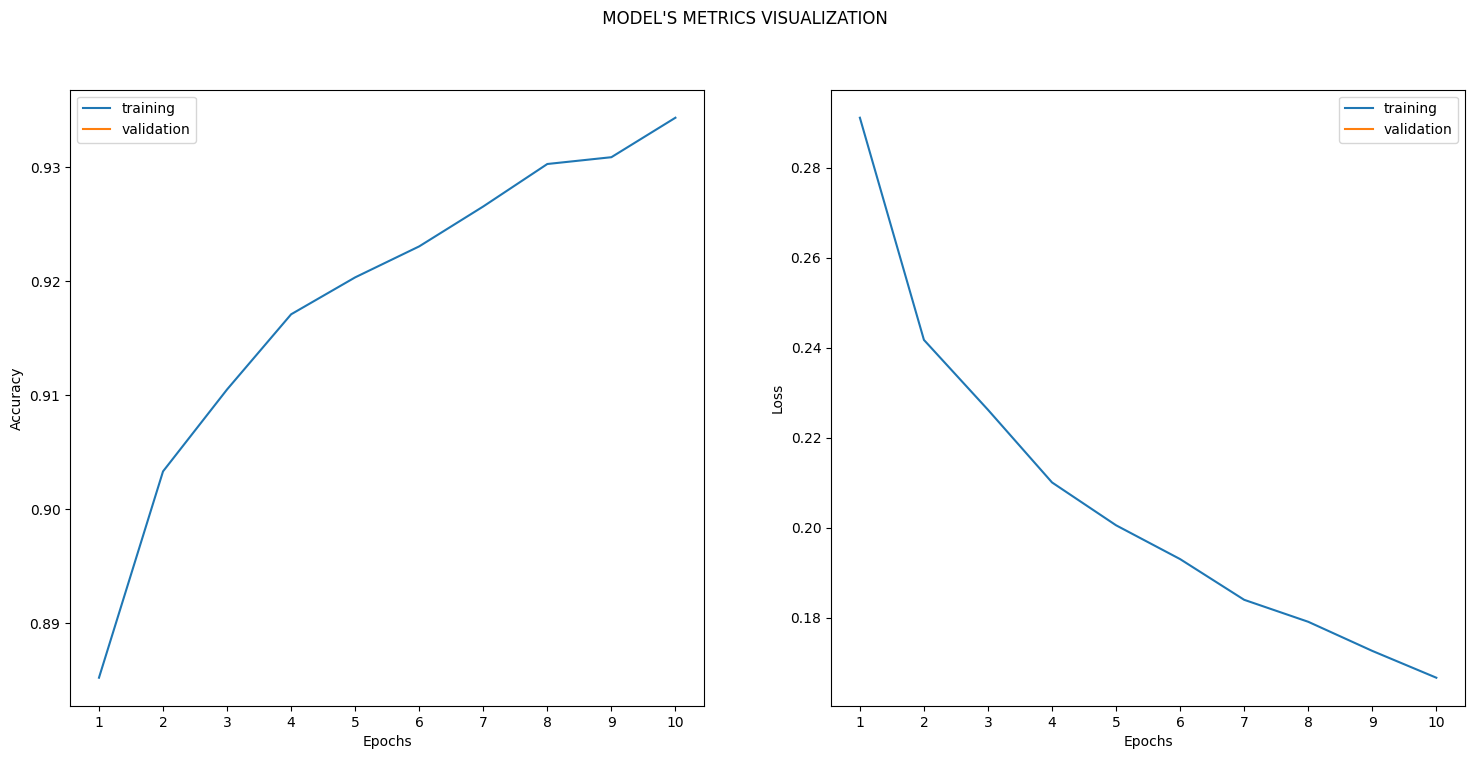

In [17]:
Train_Val_Plot(history.history['acc'],history.history['val_acc'],
               history.history['loss'],history.history['val_loss'])

In [42]:
history.history

{'loss': [0.2910670340061188,
  0.24171003699302673,
  0.22618219256401062,
  0.21004529297351837,
  0.20052634179592133,
  0.19301410019397736,
  0.18397372961044312,
  0.17909210920333862,
  0.17262542247772217,
  0.16666622459888458],
 'acc': [0.8851774334907532,
  0.9032955765724182,
  0.9104906320571899,
  0.9170891642570496,
  0.9203325510025024,
  0.9230539798736572,
  0.9265583157539368,
  0.9302862882614136,
  0.9308828115463257,
  0.9343498349189758],
 'val_loss': [0.23084495961666107],
 'val_acc': [0.9060542583465576],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}

# Saving Model and perfomance for future use


In [32]:
import pandas as pd
hist_df = pd.DataFrame(history.history['acc']) 
hist_csv_file = 'VGG_transfer_acc.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [33]:
hist_df = pd.DataFrame(history.history['acc']) 
hist_csv_file = 'VGG_transfer_loss.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [23]:
final_model.save('LesionDetection.keras')

In [34]:
y_pred_prob = final_model.predict(x_test)


105/105 [==============================] - 12s 114ms/step


# Metrics

In [35]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [40]:
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate the confusion matrix
confusion = confusion_matrix(y_test,y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test,y_pred, average='weighted')
recall = recall_score(y_test,y_pred, average='weighted')
f1 = f1_score(y_test,y_pred, average='weighted')

print("Confusion Matrix:")
print(confusion)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Confusion Matrix:
[[2862   58]
 [ 188  246]]
Precision: 0.92
Recall: 0.93
F1 Score: 0.92


<Axes: >

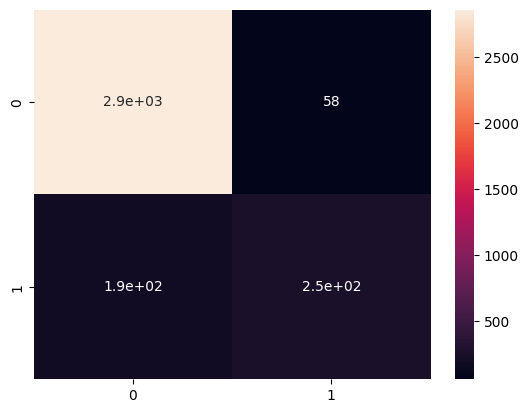

In [41]:
import seaborn as sns
sns.heatmap(confusion, annot=True)